## MTurk Data Generation with MS-COCO Dataset

Note that the `.npy` files are pre-processed and saved from previous Coral experiments (`HazyResearch/coral/visual_genome/`). This notebook goes through the objects in each notebook and filters them. It also adds numbers to each bounding box for Turkers to refer to while writing explanations. Finally, it presents a set of images and valid explanations to test the parser. 

The query of interest is: **The highlighted boxes depict a person biking on a street** 

Note each candidate now is a (person,bike) bounding box pair instead of the entire image. This parallels the Spouses task as well. Also, this is different from the Coral experiments since it uses the MS COCO bounding box information, not the captions and annotations from Visual Genome, which were noisy (Coral was accounting for primitive noise as well, so this made sense)


__FOR SOME REASON, THE IMAGES LOADED FROM THE VG DATABASE ARE DIFFERENT FROM THE MSCOCO DATABASE. THEY LOOK THE SAME BUT ARE DIFFERENT SIZES. I THINK. ANYWAY. DONT LOAD VG IMAGES.__

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os
import sys
sys.path.append('/dfs/scratch0/paroma/coco')
sys.path.append('/dfs/scratch0/paroma/coco/PythonAPI/')

from pycocotools.coco import COCO
import skimage.io as io
import pylab
import cv2

import pandas as pd

## Load Visual Genome Data
Load the train and validation sets for this task (pre-processed earlier). Split into train and validation based on splits from MS-COCO.

In [7]:
vg_folder = '/dfs/scratch0/paroma/visual_genome/'
train_mscoco = np.load(vg_folder+'train_mscoco.npy')
val_mscoco = np.load(vg_folder+'val_mscoco.npy')

train_ground = np.load(vg_folder+'train_ground.npy')
val_ground = np.load(vg_folder+'val_ground.npy')

In [8]:
#sizes of train-val-test
print "Train Set Size: ", np.shape(train_mscoco)[0], " Positive: ", np.shape(np.where(train_ground == 1))[1] 
print "Val Set Size: ", np.shape(val_mscoco)[0], " Positive: ", np.shape(np.where(val_ground == 1))[1] 

Train Set Size:  903  Positive:  270
Val Set Size:  429  Positive:  86


## Load MS-COCO Data
Load the annotations for train and validation from MS-COCO database.

In [9]:
def generate_anns(filename, coco_ids):
    coco=COCO(filename)
    catIds = coco.getCatIds(catNms=['person','bicycle']);
    set_anns = []

    for set_id in coco_ids:
        annIds = coco.getAnnIds(imgIds=set_id, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)

        temp_list = []
        for i in xrange(len(anns)):
            temp_dict = {'category_id':anns[i]['category_id'], 'bbox':anns[i]['bbox']}
            temp_list.append(temp_dict)
        set_anns.append(temp_list)
        
    return set_anns

In [10]:
from pycocotools.coco import COCO
coco_path = '/dfs/scratch0/paroma/coco/annotations/'

train_anns = generate_anns(coco_path+'instances_train2014.json', train_mscoco)
val_anns = generate_anns(coco_path+'instances_val2014.json', val_mscoco)

loading annotations into memory...
Done (t=26.72s)
creating index...
index created!
loading annotations into memory...
Done (t=13.50s)
creating index...
index created!


## New Task Instructions
For each image, we now want to:
* Create separate lists of box indices that are person and that are bike
* Create list of tuples of "person,bike"
* Iterate through pairs to check which ones overlap, only save those

Re-calculate the number of candidate pairs and the class balance.

In [11]:
def get_person_bike_boxes(anns):
    person_indices = []
    bike_indices = []
    
    for i in xrange(len(anns)):
        if anns[i]['category_id'] == 1:
            person_indices.append(i)
        if anns[i]['category_id'] == 2:
            bike_indices.append(i)
    
    return person_indices, bike_indices

In [12]:
def overlap(box1, box2):
    if (box1[0]+box1[2]<box2[0] or box2[0]+box2[2]<box1[0] or box1[1]+box1[3]<box2[1] or box2[1]+box2[3]<box1[1]):
        return False
    else:
        return True

In [13]:
def get_valid_pairs(anns, tuples):
    valid_tuples = []
    for person,bike in tuples:
        person_box = anns[person]['bbox']
        bike_box = anns[bike]['bbox']
        
        if overlap(person_box, bike_box):
            valid_tuples.append((person,bike))
    
    return valid_tuples

In [14]:
person_indices, bike_indices = get_person_bike_boxes(train_anns[11])
person_bike_tuples = [(x,y) for x in person_indices for y in bike_indices]
get_valid_pairs(train_anns[11], person_bike_tuples)

[(2, 4), (3, 0)]

## Visualization Helper Functions

In [15]:
def annotate_image(coco_id,anns,pidx,bidx):    
    I = io.imread('http://mscoco.org/images/%d'%coco_id)   
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    
    obj_anns = anns[pidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='cyan',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'X', color='cyan', fontsize=24)

    obj_anns = anns[bidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='yellow',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'Y', color='yellow', fontsize=24)

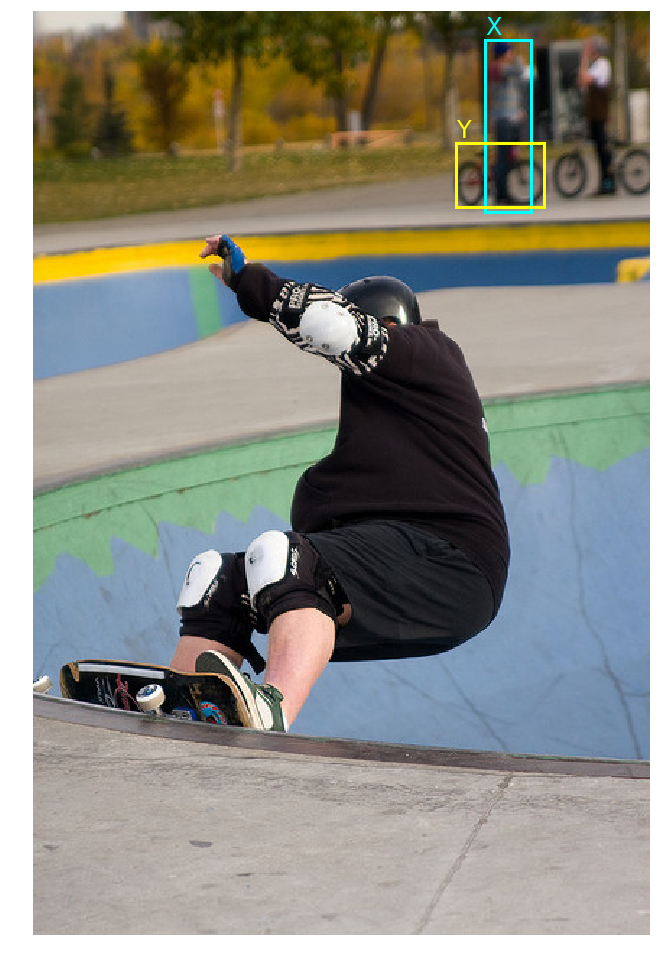

In [16]:
person_indices, bike_indices = get_person_bike_boxes(train_anns[11])
person_bike_tuples = [(x,y) for x in person_indices for y in bike_indices]
valid_pairs = get_valid_pairs(train_anns[11], person_bike_tuples)

plt.figure(figsize=(480/36,640/36))
annotate_image(train_mscoco[11],train_anns[11],valid_pairs[0][0], valid_pairs[0][1])

### Save Train Images

In [ ]:
def save_annotated_image(train_id,coco_id,anns,pidx,bidx):    
    I = io.imread('http://mscoco.org/images/%d'%coco_id)   
    h,w = np.shape(I)[0:2]
    plt.figure(figsize=(h/36,w/36))
    
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    
    obj_anns = anns[pidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='cyan',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'X', color='cyan', fontsize=24)

    obj_anns = anns[bidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='yellow',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'Y', color='yellow', fontsize=24)
    
    plt.savefig('/dfs/scratch0/paroma/visual_genome/train_%d_%d_%d'%(train_id,pidx,bidx), bbox_inches='tight')
    plt.close()

In [ ]:
invalid = []
for i in xrange(len(train_anns)):
    if i%25 == 0:
        print i
    #Find all valid person-bike pairs for given object
    person_indices, bike_indices = get_person_bike_boxes(train_anns[i])
    person_bike_tuples = [(x,y) for x in person_indices for y in bike_indices]
    if person_bike_tuples == []:
        print 'Image ' + str(i) + ' has no person-bike pairs' 
        invalid.append(i)
         
    valid_pairs = get_valid_pairs(train_anns[i], person_bike_tuples)
    if valid_pairs == []:
        print 'Image ' + str(i) + ' has no valid person-bike pairs' 
        invalid.append(i)
    
    for j in xrange(len(valid_pairs)):
        save_annotated_image(i,train_mscoco[i],train_anns[i],valid_pairs[j][0], valid_pairs[j][1])

0
Image 8 has no valid person-bike pairs
Image 10 has no valid person-bike pairs
Image 13 has no valid person-bike pairs
25
Image 25 has no valid person-bike pairs
Image 28 has no valid person-bike pairs
Image 32 has no valid person-bike pairs
50
Image 65 has no valid person-bike pairs
75
Image 82 has no valid person-bike pairs
Image 83 has no valid person-bike pairs
Image 87 has no valid person-bike pairs
Image 88 has no valid person-bike pairs
Image 90 has no valid person-bike pairs
Image 91 has no valid person-bike pairs
Image 95 has no valid person-bike pairs
100
Image 107 has no valid person-bike pairs
Image 109 has no valid person-bike pairs
Image 111 has no valid person-bike pairs
Image 114 has no valid person-bike pairs
125
Image 126 has no valid person-bike pairs
Image 130 has no valid person-bike pairs
Image 136 has no valid person-bike pairs
Image 137 has no valid person-bike pairs
Image 144 has no valid person-bike pairs
Image 146 has no valid person-bike pairs
Image 147 ha

In [ ]:
print len(invalid)